In [20]:
from pyro.contrib.autoguide import AutoDelta, AutoMultivariateNormal, AutoDiagonalNormal, AutoLowRankMultivariateNormal
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete, Trace_ELBO
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
from collections import defaultdict
from scipy.linalg import block_diag
from scipy.spatial import distance
import pyro.distributions as dist
from scipy.io import loadmat
from pyro.optim import Adam
import visualization as V
from pyro import poutine
import numpy as np
import scipy.stats
import torch
import pyro
import os

In [11]:
# SAMPLING FROM A DISTRIBUTION

loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)


import pyro.distributions as dist

d = dist.MultivariateNormal(torch.ones((1,3)), torch.eye(3))


sample tensor(-1.8786)
log prob tensor(-2.6835)


In [12]:
# DEFINING A JOINT PROBABILITY DISTRIBUTION

def weather():
    cloudy = torch.distributions.Bernoulli(0.3).sample()
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = torch.distributions.Normal(mean_temp, scale_temp).rsample()
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('sunny', 81.11529541015625)
('sunny', 73.51113891601562)
('sunny', 74.87336730957031)


In [16]:
# SIMPLE MODEL

def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    return pyro.sample("measurement", dist.Normal(weight, 0.75))


# CONDITIONING ON OBSERVED DATA
# Approach 1
# conditioned_scale = pyro.condition(scale, data={"measurement": 9.5})

conditioned_scale = pyro.condition(scale, data={"measurement": torch.tensor(9.5)})

# print(conditioned_scale)

# # Approach 2
# def scale_obs(guess):  # equivalent to conditioned_scale above
#     weight = pyro.sample("weight", dist.Normal(guess, 1.))
#      # here we condition on measurement == 9.5
#     return pyro.sample("measurement", dist.Normal(weight, 1.), obs=9.5)


_bound_partial(functools.partial(<function _context_wrap at 0x000001FC7579BB80>, <pyro.poutine.condition_messenger.ConditionMessenger object at 0x000001FC0A1E31C0>, <function scale at 0x000001FC757708B0>))


In [17]:
# CONSTRAINTS
def scale_parametrized_guide(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.))
    return pyro.sample("weight", dist.Normal(a, torch.abs(b)))

def scale_parametrized_guide_constrained(guess):
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", dist.Normal(a, b))  # no more torch.abs


In [23]:
# STOCHASTIC VARIATIONAL INFERENCE

guess = 8.5

pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses, a,b  = [], [], []
num_steps = 2500
for t in range(num_steps):
    losses.append(svi.step(guess))
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())


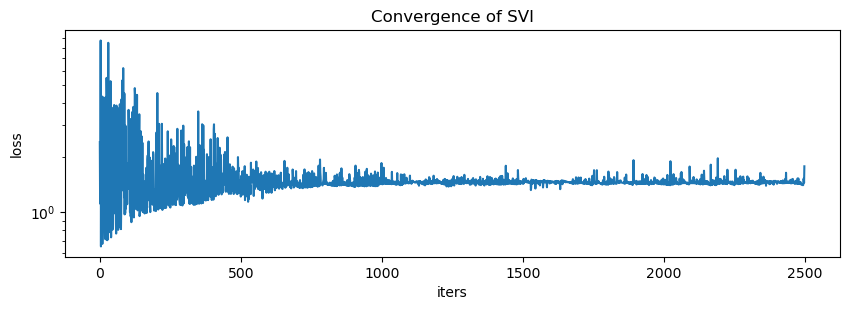

a =  9.143349647521973
b =  0.6234695911407471


In [22]:
V.plot_loss(losses)
print('a = ',pyro.param("a").item())
print('b = ', pyro.param("b").item())


In [24]:
# DEFAULT ADAM OPTIMIZER
adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)

# CUSTOMIZED ADAM OPTIMIZER (different learning rate for each parameter)

def per_param_callable(module_name, param_name):
    if param_name == 'my_special_parameter':
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}

optimizer = Adam(per_param_callable)
